## Import the libs

In [38]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import pickle

## Import and read the data

In [4]:
data_path = "./data/amazon_data.csv"
data = pd.read_csv(data_path)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
1,2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2,2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
3,2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
4,2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000
...,...,...,...,...,...,...,...
6032,2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
6033,2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
6034,2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
6035,2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000


In [5]:
close_data = data['Adj Close'].values
close_data

array([  4.46875   ,   4.09687519,   3.48749995, ..., 153.33999634,
       153.38000488, 151.94000244])

## Processing data

In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data.reshape(-1, 1))
print(type(scaled_data))
print(scaled_data)
np.save('amazon_scaled.npy', scaled_data)

<class 'numpy.ndarray'>
[[-0.64884094]
 [-0.65605641]
 [-0.66788009]
 ...
 [ 2.2397016 ]
 [ 2.24047789]
 [ 2.21253758]]


### Plotting

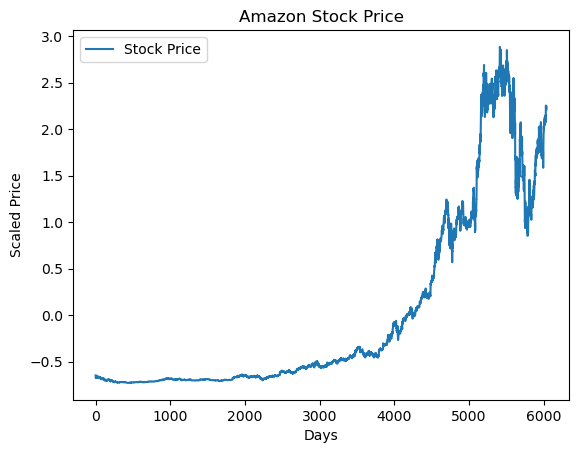

In [7]:
plt.figure(edgecolor='blue')
plt.title('Amazon Stock Price')
plt.xlabel('Days')
plt.ylabel('Scaled Price')
plt.plot(scaled_data, label='Stock Price')
plt.legend()
plt.savefig('./figs/stock_price.png')
plt.show()


## Train, test and CV data

In [8]:
def window_size(data, size):
    X = []
    y = []
    i = 0

    while (i + size) <= len(data) - 1:
        X.append(data[i:i+size])
        y.append(data[i+size])
        i += 1
    
    assert len(X) == len(y)
    
    return X, y

X, y = window_size(scaled_data, 7)

In [9]:
data_size = len(X)
split_percnt = 0.8
split_point=round(len(data)*split_percnt)

X_train = np.array(X[:split_point])
y_train = np.array(y[:split_point])

X_test = np.array(X[split_point:])
y_test = np.array(y[split_point:])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

np.save('./data/X_train.npy', X_train)
np.save('./data/y_train.npy', y_train)
np.save('./data/X_test.npy', X_test)
np.save('./data/y_test.npy', y_test)

(4830, 7, 1) (4830, 1)
(1200, 7, 1) (1200, 1)


## model

In [222]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## training

In [223]:
history = model.fit(x=X_train,y=y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Train on 4830 samples, validate on 1200 samples
Epoch 1/300
4830/4830 [==============================] - 3s 579us/sample - loss: 0.0119 - val_loss: 0.2685
Epoch 2/300


c:\Users\mpps\anaconda3\envs\lstmenv\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4830/4830 [==============================] - 2s 315us/sample - loss: 0.0042 - val_loss: 0.1719
Epoch 3/300
4830/4830 [==============================] - 1s 256us/sample - loss: 7.1283e-04 - val_loss: 0.2689
Epoch 4/300
4830/4830 [==============================] - 1s 295us/sample - loss: 0.0011 - val_loss: 0.4263
Epoch 5/300
4830/4830 [==============================] - 1s 234us/sample - loss: 0.0026 - val_loss: 0.5188
Epoch 6/300
4830/4830 [==============================] - 1s 247us/sample - loss: 0.0040 - val_loss: 0.7797
Epoch 7/300
4830/4830 [==============================] - 1s 223us/sample - loss: 0.0035 - val_loss: 0.5829
Epoch 8/300
4830/4830 [==============================] - 1s 270us/sample - loss: 0.0132 - val_loss: 0.5327
Epoch 9/300
4830/4830 [==============================] - 1s 237us/sample - loss: 0.0028 - val_loss: 0.3152
Epoch 10/300
4830/4830 [==============================] - 1s 289us/sample - loss: 0.0077 - val_loss: 0.1818
Epoch 11/300
4830/4830 [====================

In [224]:
model.save("./model/lstm.h5")

In [10]:
model = load_model("./model/lstm.h5")

# load trainning history
with open('./model/history.pkl', 'rb') as file:
    history_loaded = pickle.load(file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


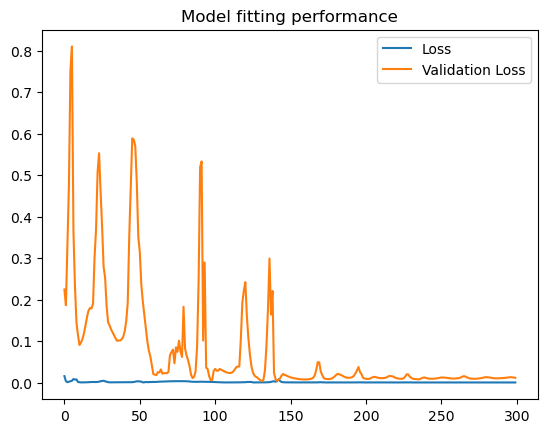

In [11]:
axes=plt.axes()
axes.plot(pd.DataFrame(history_loaded)['loss'], label='Loss')
axes.plot(pd.DataFrame(history_loaded)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')
plt.savefig('./figs/model-fitting.png')

In [12]:
y_predicted=scaler.inverse_transform(model.predict(X_test))
y_true=scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))

(1200, 1)


c:\Users\mpps\anaconda3\envs\lstmenv\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


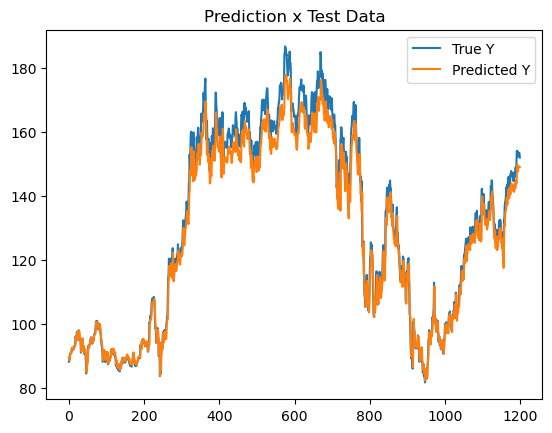

In [13]:
axes = plt.axes()
axes.plot(y_true, label='True Y')
axes.plot(y_predicted, label='Predicted Y')
axes.legend(loc=0)
axes.set_title('Prediction x Test Data')
plt.savefig('./figs/prediction_test_data.png')

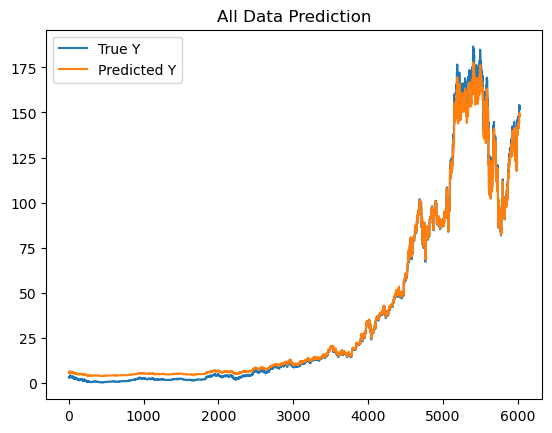

In [14]:
X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((y_train, y_test), axis=0)

y_predicted=scaler.inverse_transform(model.predict(X_data))
y_true=scaler.inverse_transform(y_data.reshape(y_data.shape[0],1))

axes = plt.axes()
axes.plot(y_true, label='True Y')
axes.plot(y_predicted, label='Predicted Y')
axes.legend(loc=0)
axes.set_title('All Data Prediction')
plt.savefig('./figs/all_data_prediction.png')

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE (Erro Médio Absoluto)
mae = mean_absolute_error(y_true, y_predicted)

# MSE (Erro Quadrático Médio)
mse = mean_squared_error(y_true, y_predicted)

# RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 2.229696789542043
Mean Squared Error: 8.244846579947144
Root Mean Squared Error: 2.871384087848079


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def predict_future(model, scaled_data, n_days, scaler):
    future_predictions = []
    
    X, _ = window_size(scaled_data, 7)
    X_data = np.array(X)
    current_input = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))[-1]

    for _ in range(n_days):
        seq = current_input[-7:].reshape((1, 7, 1))
        y_pred = model.predict(seq)
        y_pred_rescaled = scaler.inverse_transform(y_pred).reshape(-1)
        future_predictions.append(y_pred_rescaled[0])
        
        current_input = np.append(current_input[1:], y_pred)
    
    return np.array(future_predictions)

            Date   Adj Close
0     2000-01-03    4.468750
1     2000-01-04    4.096875
2     2000-01-05    3.487500
3     2000-01-06    3.278125
4     2000-01-07    3.478125
...          ...         ...
6085  2024-03-12  175.389999
6086  2024-03-13  176.559998
6087  2024-03-14  178.750000
6088  2024-03-15  174.419998
6089  2024-03-18  174.479996

[6090 rows x 2 columns]
6090


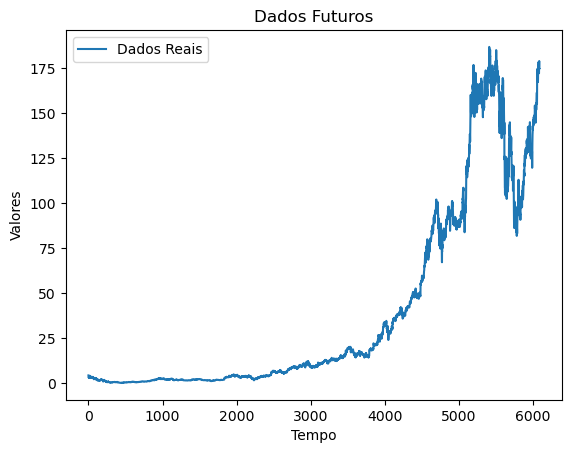

In [17]:
latest_data = pd.read_csv('./data/amazon_data_latest.csv')
latest_data = latest_data[["Date", "Adj Close"]]
latest_data = latest_data[:len(y_data)+60]
latest_data_amazon = latest_data.copy()
print(latest_data)
print(len(y_data)+60)

plt.plot(latest_data["Adj Close"], label='Dados Reais')
plt.title('Dados Futuros')
plt.xlabel('Tempo')
plt.ylabel('Valores')
plt.legend()
plt.show()


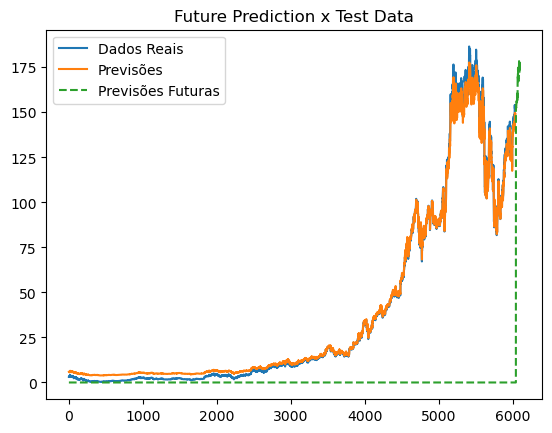

In [18]:
split = len(latest_data) - len(y_data)
latest_data = latest_data[-split:]
latest_data_close = latest_data["Adj Close"].values

scaler = StandardScaler()
scaled_data_future = scaler.fit_transform(latest_data_close.reshape(-1, 1))

X_future, y_future = window_size(scaled_data_future, 7)
X_future = np.array(X_future)
y_future = np.array(y_future)

y_predicted_future=scaler.inverse_transform(model.predict(X_future))
y_true_future=scaler.inverse_transform(y_future.reshape(y_future.shape[0],1))

future = np.zeros(len(latest_data_amazon))
future[-len(y_predicted_future):] = y_predicted_future.reshape(-1)

axes = plt.axes()
axes.plot(range(len(y_true)), y_true, label='Dados Reais')
axes.plot(range(len(y_true)), y_predicted, label='Previsões')
axes.plot(range(len(y_true)+60), future, label='Previsões Futuras', linestyle='--')
axes.legend(loc=0)
axes.set_title('Future Prediction x Test Data')
plt.savefig('./figs/future_prediction_test_data.png')
plt.show()